In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import itertools
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from lab_4_functions import word_plotter, nmf_metrics

# Step 1 EDA 
## Training Data

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


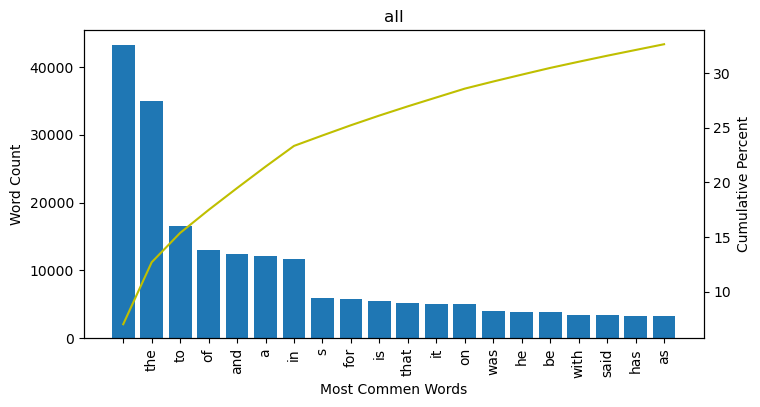

In [2]:
# First import the data and take a look at it
df_train = pd.read_csv('BBC News Train.csv')
print(df_train.head())
# I made a function to plot a cumulative histogram of the n most common words, see lab_4_functions.py for details 
word_plotter(df_train, num_words = 20)

From the above graph we can see that the most common words aren't going to provide much information for classifying the text documents. Lets try filtering out words and see if we can get a more useful data set. Sklearn has a list of English stop words that provide a good starting point. 

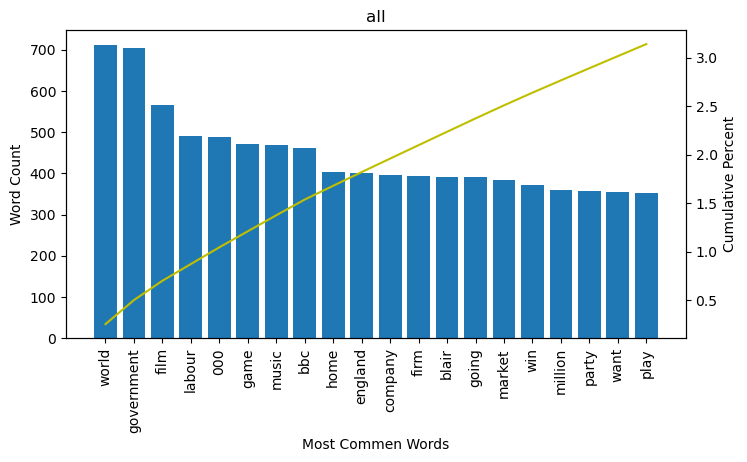

In [3]:
from sklearn.feature_extraction import text
filter_words = list(text.ENGLISH_STOP_WORDS)
# The below list was generated by repeatedly running this cell and adding words that I didn’t think 
# would be useful for classification.
train_filter_words = filter_words + ['', 's', 'said', '-', 'said.', '.', 'mr', 't', 'year','new', 'just', 'best', 'like',
                'said:', 'way', 'use', 'say', 'including', 'set', 'used', 'o', 'people', 'm', 'uk', 
                'brown', 'told', 'time', 'make', 'number', 'good', 'says', 'years', 'won']
word_plotter(df_train, num_words = 20, filter_words = train_filter_words)

As a check let's look at the top ten words for each category.

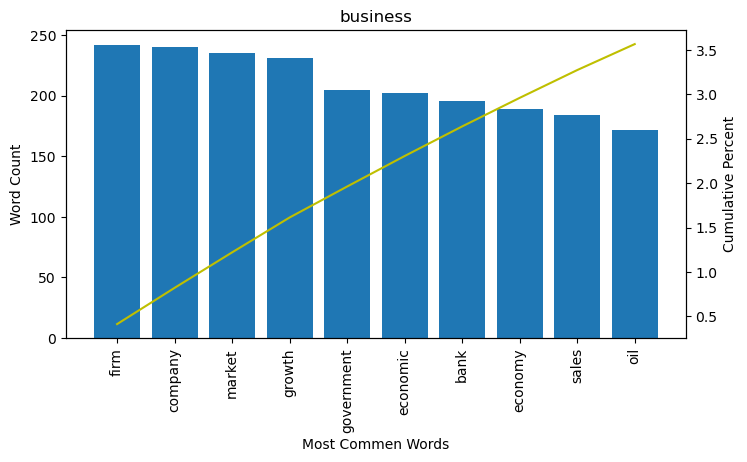

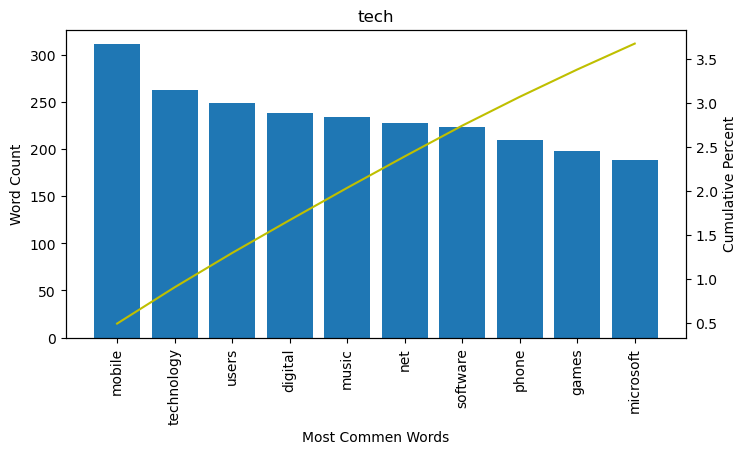

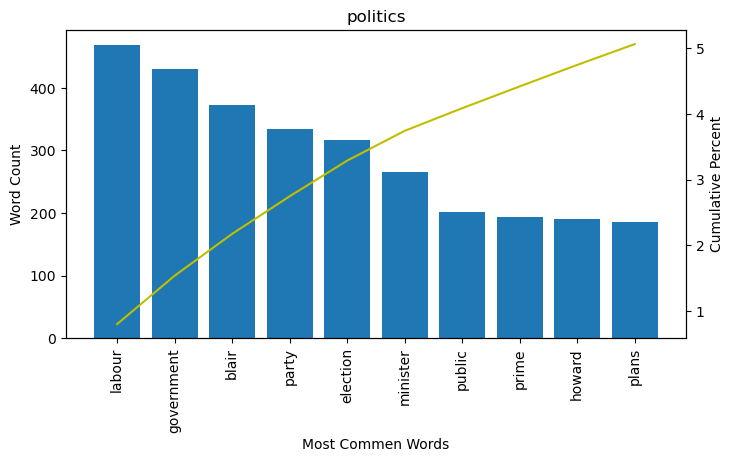

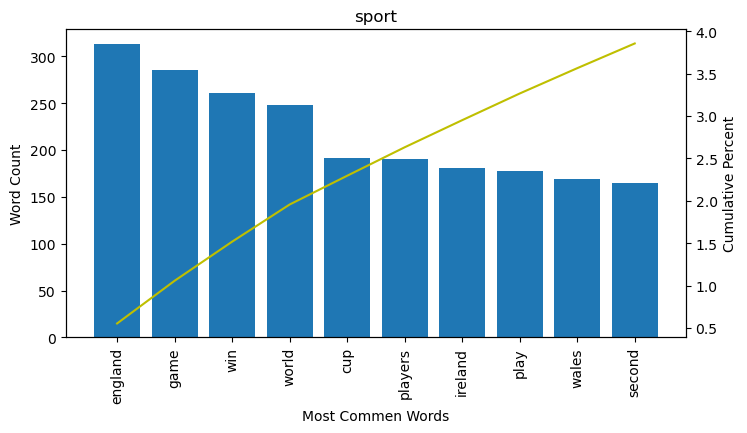

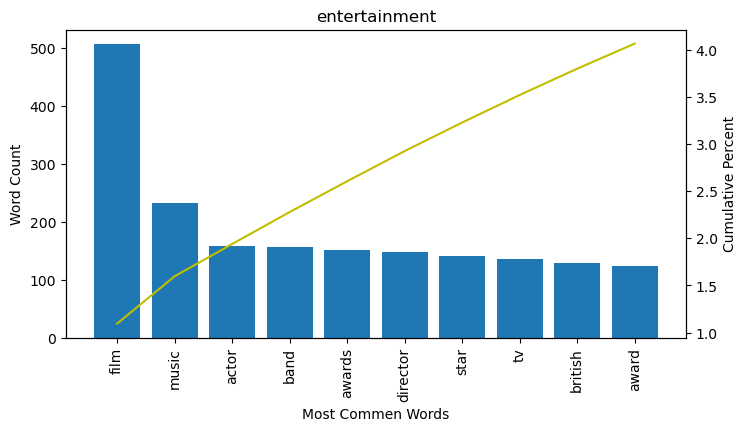

In [4]:
for cat in df_train.Category.unique():
    word_plotter(df_train, num_words = 10, filter_words = train_filter_words, cat = cat)#, show_words = True)

Based on the above graphs the top ten words for each category should be useful in classifying the documents. One thing of interest is that the top ten words for each category only make up three to four percent of the total word count. It was less than I expected it to be, but does indicate I have found a good list of filter words to use.

## Test Data

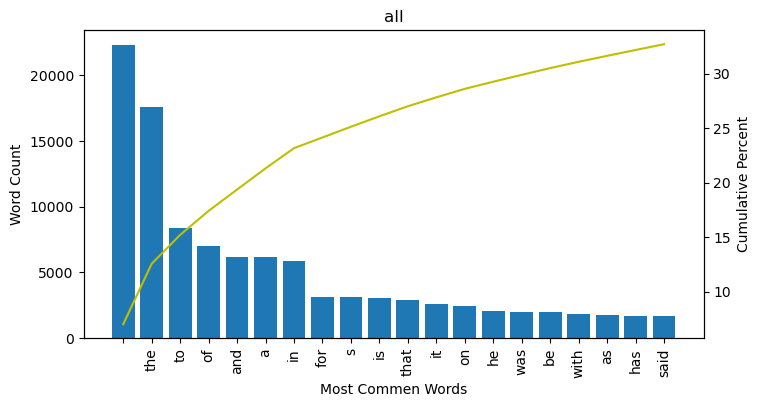

In [5]:
# Import the Test data and take a look at it
df_test = pd.read_csv('BBC News Test.csv')
df_test.head()
# Plot a cumulative histogram of the unfiltered data
word_plotter(df_test, num_words = 20)

The top 20 words for all articles are ['government', 'world', 'time', 'make', 'best', 'uk', 'music', 'labour', 'bbc', 'game', 'way', 'company', 'film', '000', 'party', 'games', 'technology', 'home', 'work', 'market']


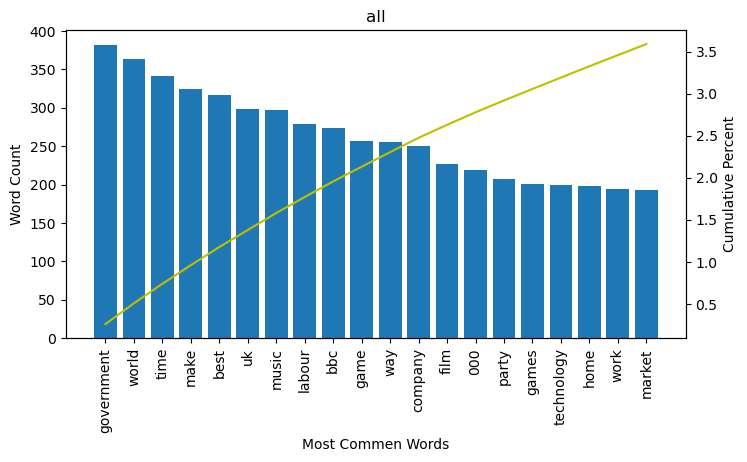

In [6]:
# make a new filter list and replot the data
test_filter_words = filter_words + ['', 's', 'said', '-', 'mr', 'people', 'new', 't', 'said.', '.', 'just', 'told', 'like', 'years', 'year',
                                   'think', 'said:', 'number', 'going', 'set', 'says', 'did', 'good']
word_plotter(df_test, num_words = 20, filter_words = test_filter_words, show_words = True)

### “When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix?" 

I am assuming since NMF is unsupervised and you don’t train an unsupervised model this is referring to the preprocessing of the data. In which case no data from the training data should be included in the preprocessing of the test data. When we vectorise the data any words present from the training dataset but not in the test dataset would complicate the model and potentially lead to poorer results. 

Keeping with the above reasoning there should be a second list of filter words for the test data. 

## TFID and Text Vectorization

Before we can run NMF we need to vectorise the data, one method to do that is TFID. TFID stands for Term Frequency Inverse Document Frequency. The idea is that common words that appear across many documents won't help in classification and are weighted less while words that appear in fewer documents are weighted more. The frequency a term is used in a single document is also considered and is weighted more heavily the more often that term appears in a document. From sklearn the equation is “tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False ), where n is the total number of documents in the document set and df(t) is the document frequency of t.” 

To do that calculation the TfidfVectorizer first has to turn the raw text data into vectors. That is done by creating a dictionary where each word is assigned a token. A matrix is then created with the rows representing documents and the columns representing tokens (or words). The matrix is then filled out with each number representing the total number of times a term appeared in a document.

I will use Sklearn's tfidf_vectorizer to preforme this process. 

In [7]:
# vectorizing the data looks like this 
tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words) # pass in the list of words so the vectorizor will exclude them
# Apply the vectorizer object to the train data and it will return a Tfidf weighted document-term matrix.
tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())

# Building and training Models.

First let's define some utility functions that will help evaluate the models.

Some important concepts expressed in the code below are that a NMF model once run has two matrices, a weight and topic matrix. The weight matrix will have the categories or topics as columns and document ids as rows. The column with the highest score indicates which category the NMF is predicting that document will be. The weight matrix has the words that the vectorizor used as columns and the topics as rows. Determining the most used words per category can be done by finding the columns with the highest scores. 

In [9]:
def run_nmf_train(min_df = 0, max_df = 1, plot = False, use_df = False):
    """Since I will be performing this multiple times I wrote a function that vectorises the data
    and optionally a plot can be printed showing the resulting top words per category as predicted 
    by the NMF model, and the df_min and df_max variables can be passed to the vectorizor rather 
    than the list of stop words."""
    
    # Use either the list of filter words or the frequency a term appears across all document to filter words.
    if use_df == True:
        tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words)

    # Apply the vectorizer object to the train data
    tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())
    
    # make the nmf modle and set n_componets = to 5 because we have 5 catogries.
    nmf = NMF(n_components = 5, random_state = 0)
    
    # run the model
    w = nmf.fit_transform(tfidf)

    # Get accuracy and maybe plot the top words.
    acc = nmf_metrics(nmf, w, tfidf_vectorizer, plot=plot)
    return acc

def nmf_metrics(nmf, w, tfidf_vectorizer, plot=False, true_labels = None):
    """Prints out the accuracy and optionally makes a plot displaying the 
    top 10 words and categories for the nmf model results. True labels is an 
    optional list of labels that will be used as the true labels in sklearn 
    accuracy score function. The default is the labels from Kaggl’s train dataset. """

    # Convert the numerical labels to text categories and return the accuracy score.
    if true_labels is None:
        best_label, acc = label_permute_compare(df_train.Category, get_predictions(w))
    else:
        best_label, acc = label_permute_compare(true_labels, get_predictions(w))

    # Get the list of words created by the vectorizer.
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    if plot:
        # make a plot showing each catagory and its top words
        plot_top_words(nmf, tfidf_feature_names, 10, "NMF", best_label)
        
    return acc

def label_permute_compare(true_, predicted, n=5):
    """Gets the combination of labels that results in the highest accuracy. Modified from week 2."""
    perms = itertools.permutations(['business', 'tech', 'politics', 'sport', 'entertainment'])
    
    acc = 0.0
    best_order = 0
    for perm in perms:
        pred = [perm[i] for i in predicted]
        pred_acc = sum([1 for x, y, in zip(list(true_), pred) if x == y]) / len(true_)
        if pred_acc > acc:
            acc = pred_acc
            best_order = perm
            
    return best_order, acc

def plot_top_words(model, feature_names, n_top_words, title, subtitles):
    '''Takes the nmf model, a list of category names and some styling information for the graph.
    It then plots a horizontal bar chart for each category. Modified from the sklearn example here
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html'''
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # sorts the array and graps the top n indices
        top_features_ind = topic.argsort()[-n_top_words:]
        # converts indices to words
        top_features = feature_names[top_features_ind]
        # grab the top words
        weights = topic[top_features_ind]

        # make a horizontal bar chart of top n words
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(subtitles[topic_idx], fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



def get_predictions(w):
    """Get the index of the column with the highest count I.E the category and return it."""
    predictions = np.argmax(w, axis=1)
    return predictions

def show_words_for_topics(topic, words,  num_words = 10):
    '''Takes the H matrix from nmf and a matrix of the words in the text. Picks the num_words with the highest 
    score for each category and returns them'''
    return np.apply_along_axis(lambda x: words[(np.argsort(-x))[:num_words]], 1, topic)
